In [24]:
# Pulizia
from IPython import get_ipython
get_ipython().run_line_magic('clear', '')
get_ipython().run_line_magic('reset', '-f')

# Import libraries:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
import h5py
import sys
import os
import json
import time

from solver_class import FiniteElementCylinderSolver, ReducedBasisCylinderSolver

## **Check dimensions**

In [26]:
# Apri il file in modalità lettura
with h5py.File('checkpoint/step_50/matrici_RB.h5', 'r') as hf:
    # Accedi ai dataset e ricrea le matrici
    MM_RB = hf['MM_RB'][:]   #N_epsilon x N_epsilon
    FF_RB = hf['FF_RB'][:]   #N_epsilon x 1
    KK_RB = hf['KK_RB'][:]   #N_D+N_D x N_epsilon x N_epsilon
    AA_RB = hf['AA_RB'][:]   #N_epsilon
    ZZ_CO = hf['ZZ_CO'][:]   #N_D
    II_CO = hf['II_CO'][:]   #N_D x N_D
    basis = hf['basis'][:]   #mask_in_C x N_epsilon

print(MM_RB.shape[0])
print(FF_RB.shape)
print(KK_RB.shape)
print(AA_RB.shape)
print(ZZ_CO.shape)
print(II_CO.shape)
print(basis.shape)

50
(50, 1)
(16, 50, 50)
(50,)
(8,)
(8, 8)
(9900, 50)


## **L2 norm error in time**

In [25]:
# Import test set
loaded_data = np.load('L2 errors/test_set.npz')
LIST_FR = loaded_data['FR']
LIST_BC = loaded_data['BC']
LIST_LL = loaded_data['LL']
LIST_RR = loaded_data['RR']
LIST_FY = loaded_data['FY']
LIST_K = loaded_data['K']
# # LIST_GG = loaded_data['GG']

sTR = LIST_BC.shape[0]

In [29]:
dimensions = [100]
#list(range(1, 3))  # Da 1 a 57
num_time_steps = 1000
L2_error_in_time = np.zeros(num_time_steps)           #vettore dell'errore in norma L2 nel tempo per quel specifico parametro
L2_error_in_time_for_dim = np.zeros(num_time_steps)   #vettore dell'errore in norma L2 nel tempo che risulta essere il massimo per quel numero di basis
max_L2_error_for_dim = 0                              #valore massimo che viene confrontato 


MM_FO = np.load('model_files/XX_FO.npy', allow_pickle=True)[0]  # Matrice per norma L2
#with h5py.File('new algorithm/checkpoint/step_190/matrici_RB.h5', 'r') as hf:
    # Accedi ai dataset e ricrea le matrici
    #ZZ_CO = hf['ZZ_CO'][:]
    #II_CO = hf['II_CO'][:]

for dim in dimensions:
    max_L2_error_for_dim = 0 
    with h5py.File('checkpoint/step_100/matrici_RB.h5', 'r') as hf:
        basis = hf['basis'][:, :dim]

    # Itera sui set di parametri
    for i in range(sTR):
        cur_FR = LIST_FR[i]
        cur_BC = LIST_BC[i]
        cur_LL = LIST_LL[i]
        cur_RR = LIST_RR[i]
        cur_FY = LIST_FY[i]
        cur_K = LIST_K[i]
        cur_dt = 1.00E+04

        print(f"Iterazione {i+1}/{sTR} - Parametri: "
            f"FR={cur_FR:.2e}, BC={cur_BC:.2f}, LL={cur_LL:.2e}, "
            f"RR={cur_RR:.2e}, FY={cur_FY:.2f}, K={cur_K:.2f}")

        # Calcola la soluzione FOM con i parametri attuali
        solver_FO = FiniteElementCylinderSolver()
        solver_FO.assemble(RADIUS=cur_RR, LENGTH=cur_LL, F_RATE=cur_FR, 
                        F_YIELD=cur_FY, T_BC=cur_BC, KTH=cur_K, dt=cur_dt)
        solution_FO = solver_FO.solve(n_steps=num_time_steps, verbose=False)         #(9900, 1001)

        # Calcola la soluzione ROM
        solver_RB = ReducedBasisCylinderSolver(basis[:, :])
        solver_RB.assemble(RADIUS=cur_RR, LENGTH=cur_LL, F_RATE=cur_FR, 
                        F_YIELD=cur_FY, T_BC=cur_BC, KTH=cur_K, dt=cur_dt)
        solution_RB = solver_RB.solve(n_steps=num_time_steps, error_bound=False)     #(173,1001)
        solution_RB = np.dot(basis, solution_RB[:, :])                               #(9900, 1001)

        for ii in range(0, num_time_steps):
            difference = solution_FO[:, ii] - solution_RB[:, ii]
            L2_norm = np.sqrt(MM_FO.dot(difference).dot(difference)) #1
            reference_norm = np.sqrt(MM_FO.dot(solution_FO[:, ii]).dot(solution_FO[:, ii])) #1
            L2_normalized = L2_norm / reference_norm # 1
            L2_error_in_time[ii] = L2_normalized                                     #Mi salvo il vettore dell'errore in norma L2 nel tempo per quel set di parametri e dimensione
 
        
        if np.nanmax(L2_error_in_time) > max_L2_error_for_dim: 
            max_L2_error_for_dim = np.nanmax(L2_error_in_time)
            L2_error_in_time_for_dim = L2_error_in_time.copy()             #vettore nel tempo dell'errore in norma L2 che risulta essere massimo rispetto ai set di parametri

        print("\n")
     
    np.savetxt(f"L2 errors/L2_error_in_time_with_{dim}_basis.csv", L2_error_in_time_for_dim, delimiter=",")



Iterazione 1/100 - Parametri: FR=2.86e+19, BC=2496.20, LL=7.71e-04, RR=1.70e-05, FY=0.22, K=2.54


/var/folders/gs/p2p59ns16hlgpqv_027665gm0000gn/T/ipykernel_2770/1247963722.py:51: RuntimeWarning: invalid value encountered in scalar divide
  L2_normalized = L2_norm / reference_norm # 1




Iterazione 2/100 - Parametri: FR=2.78e+19, BC=2444.48, LL=1.41e-03, RR=8.91e-06, FY=0.30, K=7.16


Iterazione 3/100 - Parametri: FR=2.41e+19, BC=1618.31, LL=1.18e-04, RR=1.13e-05, FY=0.25, K=6.70


Iterazione 4/100 - Parametri: FR=3.74e+19, BC=732.27, LL=8.88e-04, RR=1.82e-05, FY=0.23, K=4.43


Iterazione 5/100 - Parametri: FR=2.11e+19, BC=773.57, LL=1.40e-03, RR=1.74e-05, FY=0.07, K=7.32


Iterazione 6/100 - Parametri: FR=1.35e+18, BC=689.34, LL=7.45e-04, RR=8.08e-06, FY=0.14, K=1.29


Iterazione 7/100 - Parametri: FR=1.23e+19, BC=839.13, LL=5.92e-04, RR=1.06e-05, FY=0.29, K=3.27


Iterazione 8/100 - Parametri: FR=1.51e+19, BC=1731.05, LL=1.01e-04, RR=1.14e-05, FY=0.06, K=5.10


Iterazione 9/100 - Parametri: FR=3.01e+19, BC=1454.64, LL=1.42e-03, RR=9.79e-06, FY=0.26, K=4.91


Iterazione 10/100 - Parametri: FR=4.89e+19, BC=946.50, LL=3.15e-04, RR=1.03e-05, FY=0.17, K=1.45


Iterazione 11/100 - Parametri: FR=5.42e+18, BC=2129.01, LL=1.08e-03, RR=1.81e-05, FY=0.12, K=5.03


Iterazione 

/var/folders/gs/p2p59ns16hlgpqv_027665gm0000gn/T/ipykernel_2770/602719624.py:27: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  ax1.set_ylim([1e-5, 0])


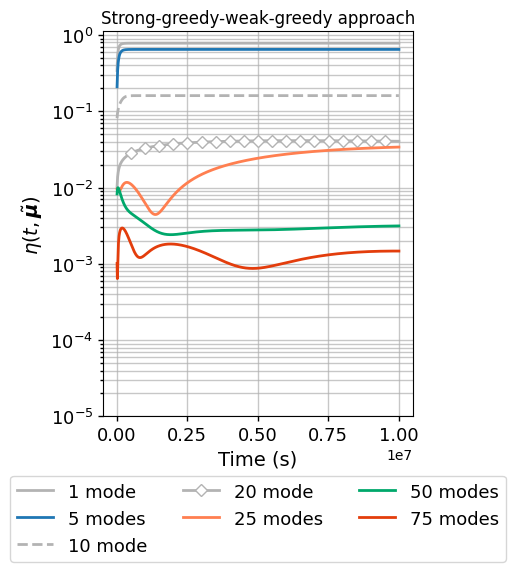

In [ ]:
data_1 = np.loadtxt("L2 errors/L2_error_in_time_with_1_basis.csv", delimiter=",")  
data_5 = np.loadtxt("L2 errors/L2_error_in_time_with_5_basis.csv", delimiter=",")     
data_10 = np.loadtxt("L2 errors/L2_error_in_time_with_10_basis.csv", delimiter=",")      
data_20 = np.loadtxt("L2 errors/L2_error_in_time_with_20_basis.csv", delimiter=",")      
data_25 = np.loadtxt("L2 errors/L2_error_in_time_with_25_basis.csv", delimiter=",")       
data_50 = np.loadtxt("L2 errors/L2_error_in_time_with_50_basis.csv", delimiter=",")       
data_75 = np.loadtxt("L2 errors/L2_error_in_time_with_75_basis.csv", delimiter=",")       
data_100 = np.loadtxt("L2 errors/L2_error_in_time_with_100_basis.csv", delimiter=",")       


time = np.linspace(0, 1e7, 1000)

fig, (ax1) = plt.subplots(1, figsize=(4,5))
ax1.set_yscale('log')
ax1.plot(time, data_1, label='1 mode', color='#b3b3b3', linewidth=2)  
ax1.plot(time, data_5, label='5 modes', linewidth=2)
ax1.plot(time,data_10, label='10 mode', color='#b3b3b3', linewidth = 2, linestyle='--')
ax1.plot(time,data_20, label='20 mode', color='#b3b3b3', linewidth = 2,  marker='D', markevery=50, markerfacecolor='white')
ax1.plot(time,data_25, label='25 modes', color = '#FF7F50', linewidth = 2)
ax1.plot(time,data_50, label='50 modes', color = '#00A86B', linewidth = 2)
ax1.plot(time,data_75, label='75 modes', color = '#e33d0c', linewidth = 2)
ax1.plot(time,data_100, label='100 modes', color = '#e33d0c', linewidth = 2)

ax1.tick_params(axis="y", which='both',labelsize=13,  width=1)
ax1.tick_params(axis='x', labelsize=13,  width=1)
ax1.set_xlabel('Time (s)',fontsize=14)
ax1.set_ylabel(r'$\eta (t, \tilde{\boldsymbol{\mu}})$',fontsize=14)
#ax1.set_xlim([0,1e7])
ax1.set_ylim([1e-5, 0])
ax1.set_title(rf'Strong-greedy-weak-greedy approach')
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.13), fancybox=True, shadow=False, ncol=3, fontsize=13)
ax1.grid(visible=True, which='both', linewidth=1, alpha=0.7)
#plt.savefig('plot/L2error_in_time.pdf', bbox_inches='tight') 